In [2]:
!pip install scikit-learn imbalanced-learn xgboost seaborn matplotlib

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.0 MB 761.4 kB/s eta 0:00:10
   --- ------------------------------------ 0.8/8.0 MB 764.7 kB/s eta 0:00:10
   --- ------------------------------------ 0.8/8.0 MB 764.7 kB/s eta 0:00:10
   ----- ---------------------------------- 1.0/8.0 MB 719.0 kB/s eta 0:00:10
   ----- ---------------------------------- 1.0/8.0 MB 719.0 kB/s eta 0:00:10
   ------ --------------------------------- 1.3/8.0 MB 687.2 kB/s eta 0:00:10
   ------ --------------------------------- 1.3/8.0 MB 687.2 kB/s eta 0:00:10
   ------- -----------------------------

Original Class Distribution:
0    4728
1     272
Name: count, dtype: int64

Class Distribution After SMOTE:
0    3546
1    3546
Name: count, dtype: int64
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1182
           1       0.68      0.81      0.74        68

    accuracy                           0.97      1250
   macro avg       0.83      0.89      0.86      1250
weighted avg       0.97      0.97      0.97      1250



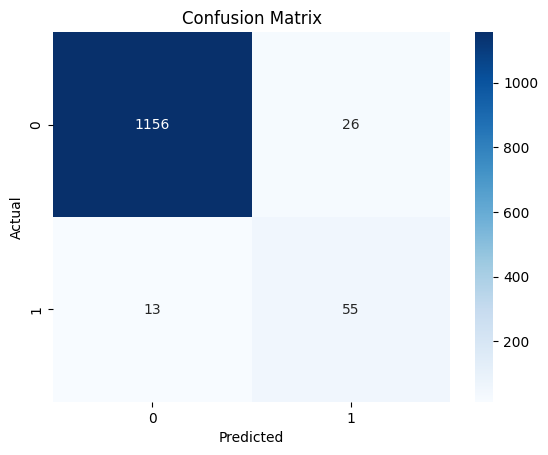

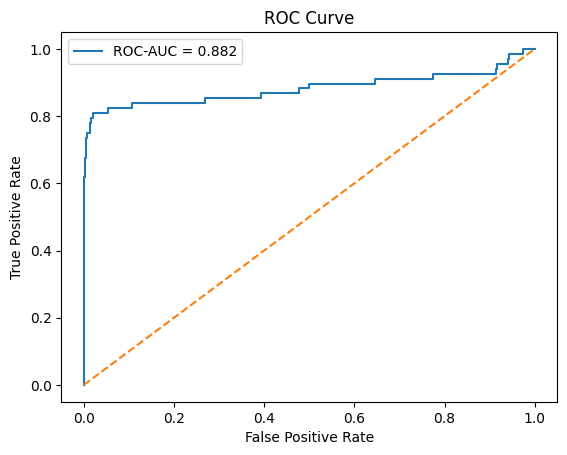

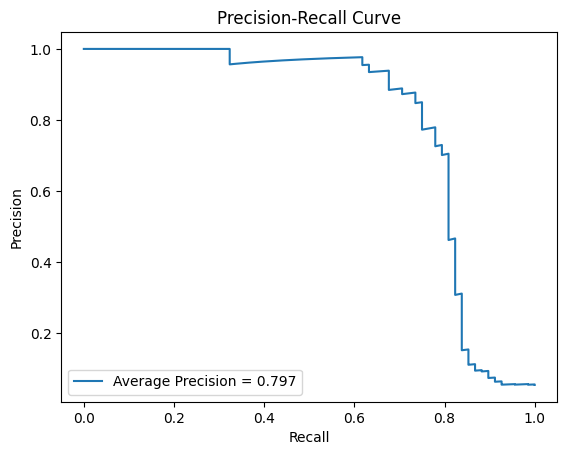

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

X, y = make_classification(
    n_samples=5000,
    n_features=20,
    n_informative=5,
    n_redundant=2,
    n_clusters_per_class=1,
    weights=[0.95, 0.05],  # Imbalanced
    random_state=42
)

print("Original Class Distribution:")
print(pd.Series(y).value_counts())


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_smote).value_counts())


scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)


param_grid = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 200]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="average_precision",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_smote, y_train_smote)
best_model = grid_search.best_estimator_

print("\nBest Hyperparameters:")
print(grid_search.best_params_)


y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.plot(recall, precision, label=f"Average Precision = {avg_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()